In [29]:
import os
import SimpleITK as sitk

In [2]:
im = sitk.ReadImage('/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/84.mha')

In [3]:
im_arr = sitk.GetArrayFromImage(im)

In [4]:
im.GetSize()

(512, 512, 305)

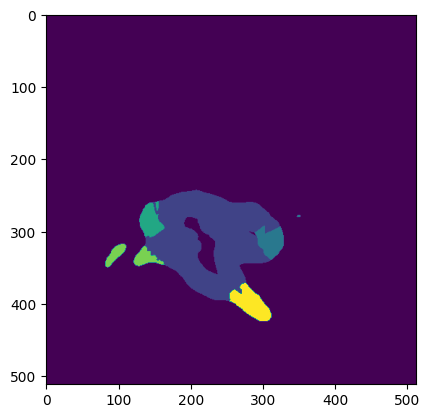

In [5]:
from matplotlib.pyplot import imshow

slices = 200
imshow(im_arr[slices,:,:])

In [6]:
im_bis = (im==1)

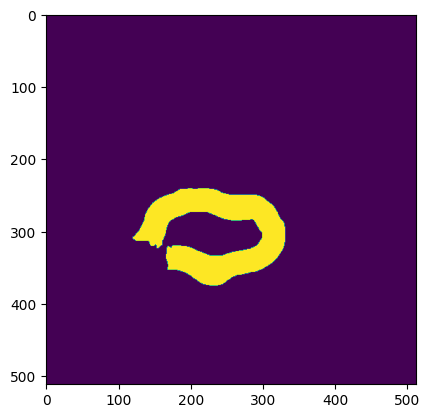

In [7]:
nda = sitk.GetArrayFromImage(im_bis)
imshow(nda[170,:,:])

In [8]:
import numpy as np
np.unique(nda)

array([0, 1], dtype=uint8)

In [9]:
test = sitk.BinaryMorphologicalClosingImageFilter().Execute(im_bis)

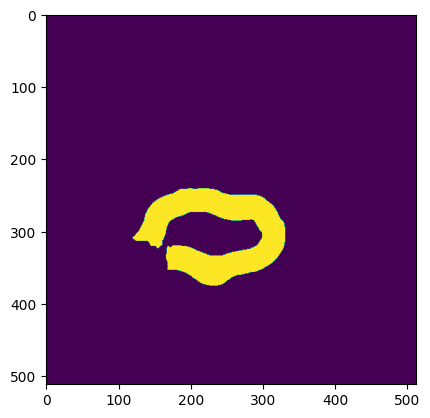

In [10]:
test_arr = sitk.GetArrayFromImage(test)
imshow(test_arr[170,:,:])

In [11]:
im_bis = (im==6)

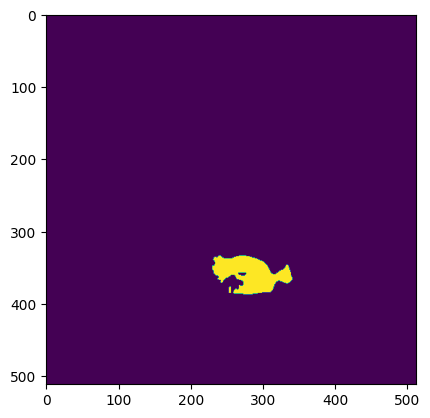

In [12]:
nda = sitk.GetArrayFromImage(im_bis)
imshow(nda[230,:,:])

In [15]:
nda2 = sitk.GetArrayFromImage(test2)
imshow(nda2[230,:,:])

NameError: name 'test2' is not defined

In [13]:
import numpy as np
np.unique(nda)

array([0, 1], dtype=uint8)

In [14]:
test = sitk.BinaryMorphologicalClosingImageFilter().Execute(im_bis)

# TESTER BinaryFillholeImageFilter

In [15]:
filters =sitk.BinaryMorphologicalClosingImageFilter()
filters.SetKernelRadius((10,10,10))
test2 =filters.Execute(im_bis)

In [16]:
test.GetSize()

(512, 512, 305)

In [17]:
test_arr.shape

(305, 512, 512)

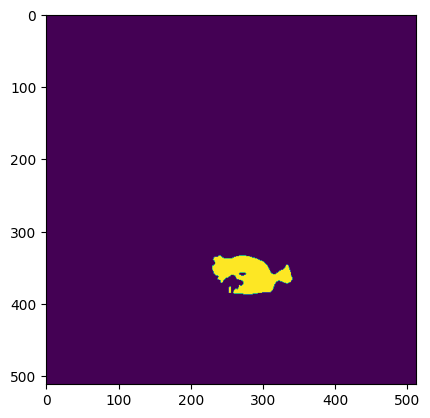

In [19]:
test_arr = sitk.GetArrayFromImage(test)
imshow(test_arr[230,:,:])

In [20]:
dataset = 'Dataset004_LA_CT00_corrected_voted'
path = f'/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/'
files = [f for f in os.listdir( path ) if f[-4:]=='.mha']

#pred_files = [f'/media/sharedata/atriumCT/atrium_nnunet/raw_data/{dataset}/prediction_3d_dataset002/' + f for f in files]
#ref_files = [f'/media/sharedata/atriumCT/atrium_nnunet/raw_data/{dataset}/labelsTr/' + f for f in files]
mask_path = '/media/sharedata/atriumCT/atrium_nnunet/raw_data/Dataset004_LA_CT00_corrected_voted/labelsTr/'

masks_files = [mask_path + f for f in os.listdir(mask_path)]
ref_label_files = ['/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/' + f  for f in files]
opacification_defect_files = ['/media/sharedata/atriumCT/corrected_data/GTopacification_defect/' + f for f in files]

In [21]:
masks_files[:5]

['/media/sharedata/atriumCT/atrium_nnunet/raw_data/Dataset004_LA_CT00_corrected_voted/labelsTr/la_trans_corrected_102_061.mha',
 '/media/sharedata/atriumCT/atrium_nnunet/raw_data/Dataset004_LA_CT00_corrected_voted/labelsTr/la_trans_corrected_103_062.mha',
 '/media/sharedata/atriumCT/atrium_nnunet/raw_data/Dataset004_LA_CT00_corrected_voted/labelsTr/la_trans_corrected_104_063.mha',
 '/media/sharedata/atriumCT/atrium_nnunet/raw_data/Dataset004_LA_CT00_corrected_voted/labelsTr/la_trans_corrected_105_064.mha',
 '/media/sharedata/atriumCT/atrium_nnunet/raw_data/Dataset004_LA_CT00_corrected_voted/labelsTr/la_trans_corrected_106_065.mha']

In [22]:
ref_label_files[:5]

['/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/102.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/103.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/104.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/105.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/106.mha']

In [23]:
opacification_defect_files[:6]

['/media/sharedata/atriumCT/corrected_data/GTopacification_defect/102.mha',
 '/media/sharedata/atriumCT/corrected_data/GTopacification_defect/103.mha',
 '/media/sharedata/atriumCT/corrected_data/GTopacification_defect/104.mha',
 '/media/sharedata/atriumCT/corrected_data/GTopacification_defect/105.mha',
 '/media/sharedata/atriumCT/corrected_data/GTopacification_defect/106.mha',
 '/media/sharedata/atriumCT/corrected_data/GTopacification_defect/107.mha']

In [24]:
from tqdm import tqdm

In [131]:
#for i in tqdm(range(4,6)):
i=0
print(ref_label_files[i])
seg_mask = sitk.ReadImage(masks_files[i])
seg_opa = sitk.ReadImage(opacification_defect_files[i])
seg_ref_label =  sitk.ReadImage(ref_label_files[i])

origin_id = int(masks_files[i][-11:-8].split('_')[-1])
print(origin_id)

if (seg_opa.GetSize() != seg_mask.GetSize()):
    seg_opa = sitk.Resample(seg_opa, seg_mask, sitk.Transform(), sitk.sitkLabelGaussian, 0, seg_opa.GetPixelID())

if (seg_ref_label.GetSize() != seg_mask.GetSize()):
    seg_ref_label = sitk.Resample(seg_ref_label, seg_mask, sitk.Transform(), sitk.sitkLabelGaussian, 0, seg_ref_label.GetPixelID())

seg_mask_arr = sitk.GetArrayFromImage(seg_mask)
seg_opa_arr = sitk.GetArrayFromImage(seg_opa)
seg_ref_label_arr = sitk.GetArrayFromImage(seg_ref_label)

# Put labels values on the total mask. It enables to fill the big holes in the corps
filled_seg_ref_label_arr = np.where(seg_ref_label_arr!=0, seg_ref_label_arr, seg_mask_arr)


# Filter on auricle label so that we can fill the holes and get a smooth delimitation between the corps and the auricle
auricle = (seg_ref_label==2)

closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
closing_filter.SetKernelType(sitk.sitkBall)
closing_filter.SetKernelRadius(int(min(auricle.GetSize())/4))
auricle_closed = closing_filter.Execute(auricle)
auricle_closed_arr = sitk.GetArrayFromImage(auricle_closed)
auricle_closed_arr = auricle_closed_arr * seg_mask_arr
seg_ref_label_closed_arr = np.where(auricle_closed_arr!=0, 2, filled_seg_ref_label_arr)

# Adding opacification_defect label
filled_seg_ref_label_with_opa_defect_arr = np.where(seg_opa_arr!=0, seg_opa_arr*7, seg_ref_label_closed_arr).astype(int)

filled_seg_ref_label_with_opa_defect_mask = sitk.GetImageFromArray(filled_seg_ref_label_with_opa_defect_arr)
filled_seg_ref_label_with_opa_defect_mask = sitk.Cast(filled_seg_ref_label_with_opa_defect_mask, sitk.sitkUInt8) # Cast necessary to be opened in MUSIC
filled_seg_ref_label_with_opa_defect_mask.CopyInformation(seg_mask)



/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/102.mha
102


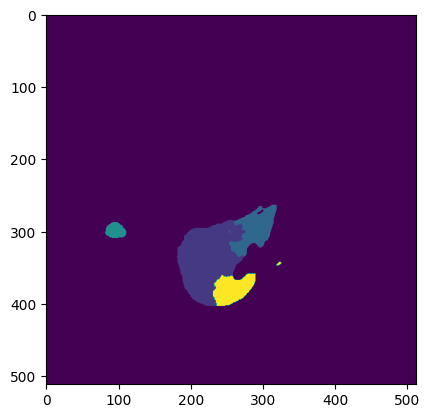

In [140]:
imshow(seg_ref_label_arr[225,:,:])

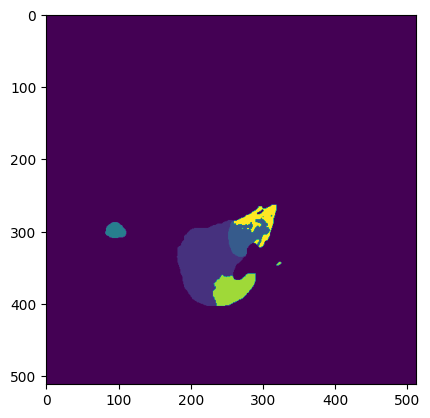

In [141]:
imshow(filled_seg_ref_label_with_opa_defect_arr[225,:,:])

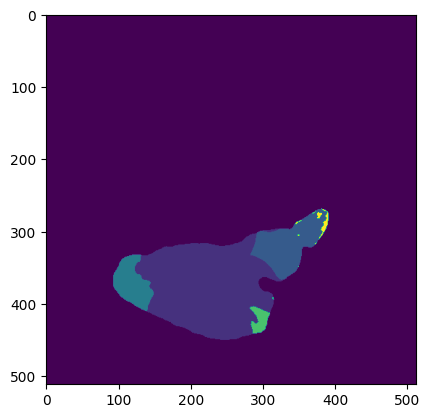

In [101]:
imshow(filled_seg_ref_label_with_opa_defect_arr[175,:,:])

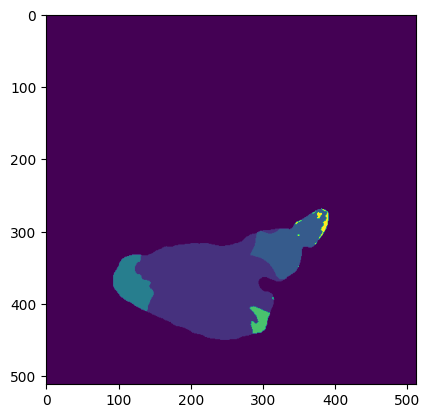

In [98]:
imshow(filled_seg_ref_label_with_opa_defect_arr[175,:,:])

In [26]:
seg_mask.GetSize() != seg_opa.GetSize()

False

In [ ]:
A = np.array([[0,1,2],[4,5,6]])
A

In [56]:
B = np.array([[7,8,9],[7,8,9]])
B

array([[7, 8, 9],
       [7, 8, 9]])

In [60]:
np.where(A!=0, A, B)

array([[7, 1, 2],
       [4, 5, 6]])

In [27]:
seg_mask_arr.shape

(271, 512, 512)

In [28]:
filled_seg_ref_label_arr = np.where(seg_ref_label_arr!=0, seg_ref_label_arr, seg_mask_arr)

In [29]:
filled_seg_ref_label_arr.shape

(271, 512, 512)

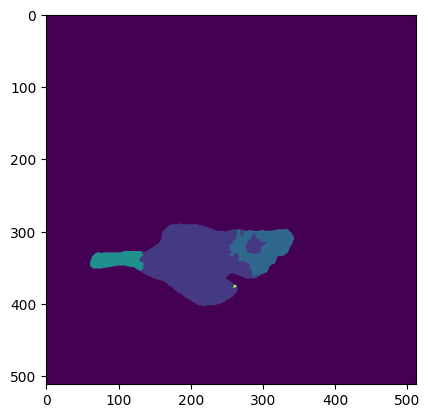

In [30]:
imshow(filled_seg_ref_label_arr[169,:,:])

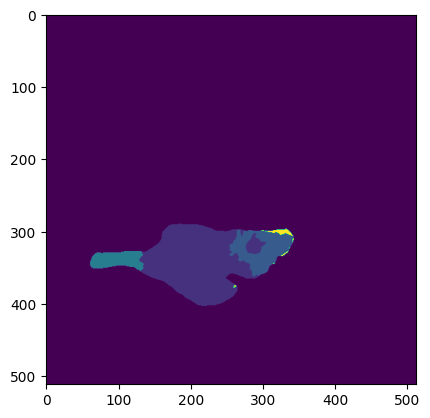

In [64]:
imshow(filled_seg_ref_label_with_opa_defect_arr[169,:,:])

In [31]:
np.unique(filled_seg_ref_label_arr)

array([0., 1., 2., 3., 4., 5., 6.])

In [32]:
filled_seg_ref_label_with_opa_defect_arr = np.where(seg_opa_arr!=0, seg_opa_arr*7, filled_seg_ref_label_arr)

In [33]:
np.unique(filled_seg_ref_label_with_opa_defect_arr)

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [34]:
filled_seg_ref_label_arr.dtype

dtype('float64')

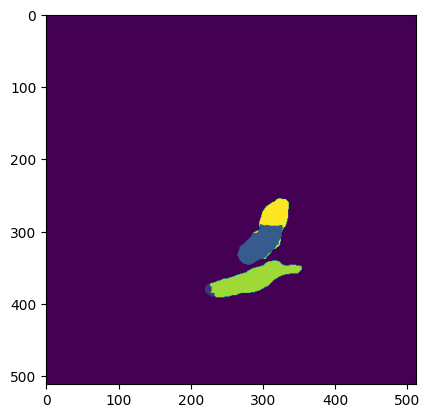

In [35]:
imshow(filled_seg_ref_label_with_opa_defect_arr[190,:,:])

In [36]:
new_im = (seg_ref_label==2)

In [67]:
###

auricle = (seg_ref_label==2)

closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
closing_filter.SetKernelType(sitk.sitkBall)
closing_filter.SetKernelRadius(int(min(auricle.GetSize())/6))
auricle_closed = closing_filter.Execute(auricle)
auricle_closed_arr = sitk.GetArrayFromImage(auricle_closed)
auricle_closed_arr = auricle_closed_arr * seg_mask_arr
seg_ref_label_closed_arr = np.where(auricle_closed_arr!=0, 2, filled_seg_ref_label_arr)


filled_seg_ref_label_with_opa_defect_arr = np.where(seg_opa_arr!=0, seg_opa_arr*7, seg_ref_label_closed_arr).astype(int)

filled_seg_ref_label_with_opa_defect_mask = sitk.GetImageFromArray(filled_seg_ref_label_with_opa_defect_arr)
filled_seg_ref_label_with_opa_defect_mask = sitk.Cast(filled_seg_ref_label_with_opa_defect_mask, sitk.sitkUInt8) # Cast necessary to be opened in MUSIC
filled_seg_ref_label_with_opa_defect_mask.CopyInformation(seg_mask)

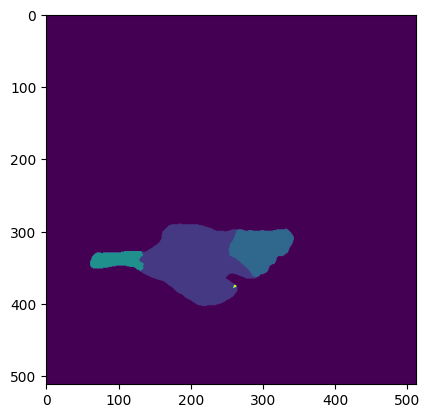

In [74]:
imshow(seg_ref_label_closed_arr[169,:,:])

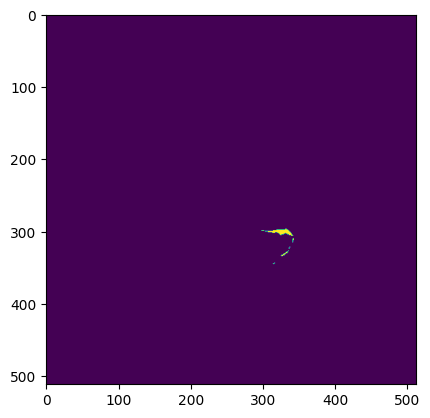

In [75]:
imshow(seg_opa_arr[169,:,:])

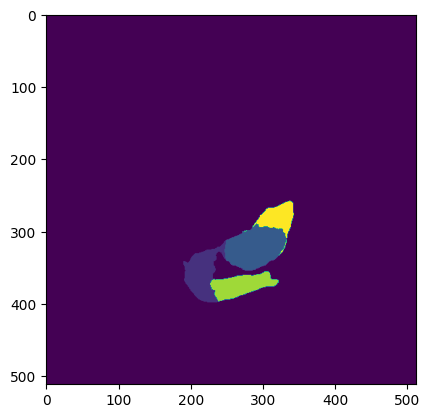

In [85]:
imshow(filled_seg_ref_label_with_opa_defect_arr[180,:,:])

In [66]:
min(new_im.GetSize())

271

In [37]:
new_im_arr = sitk.GetArrayFromImage(new_im)

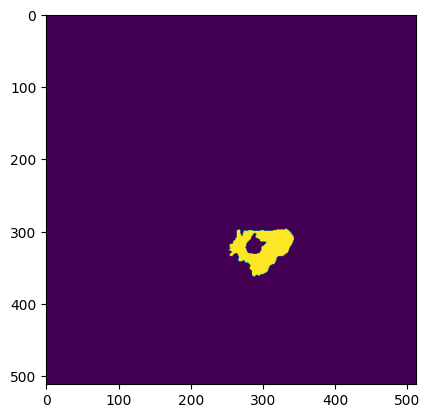

In [38]:
imshow(new_im_arr[169,:,:])

In [86]:
filters =sitk.BinaryFillholeImageFilter()
#filters.SetKernelRadius((10,10,10))
filters.SetForegroundValue(1)
filters.Set
test2 =filters.Execute(new_im)

In [71]:
np.unique(test2_arr)

array([0, 1], dtype=uint8)

In [72]:
test2_arr = sitk.GetArrayFromImage(test2)

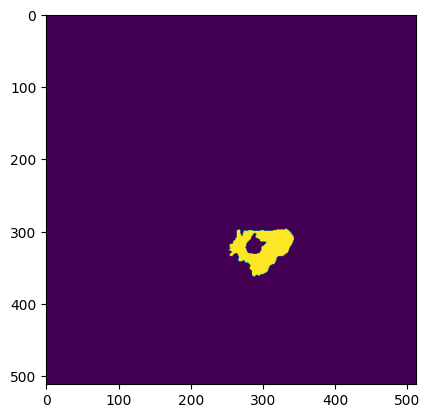

In [73]:
imshow(test2_arr[169,:,:])

In [46]:
filter1 = sitk.BinaryMorphologicalClosingImageFilter()
filter1.SafeBorderOn()
filter1.SetKernelRadius((20,20,20))
bla2 = filter1.Execute(new_im)

In [47]:
bla2_arr = sitk.GetArrayFromImage(bla2)

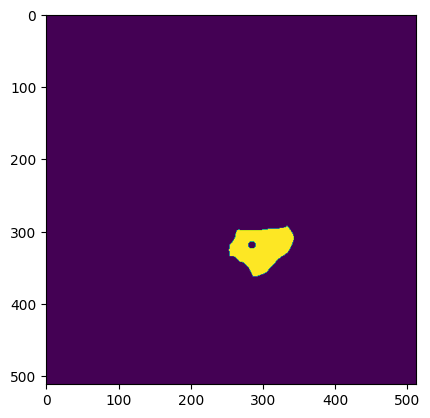

In [48]:
imshow(bla2_arr[169,:,:])

In [52]:
filter1 = sitk.BinaryMorphologicalClosingImageFilter()
filter1.SetKernelType(sitk.sitkBall)
filter1.SetKernelRadius(40)
bla2 = filter1.Execute(new_im)

In [53]:
bla2_arr = sitk.GetArrayFromImage(bla2)

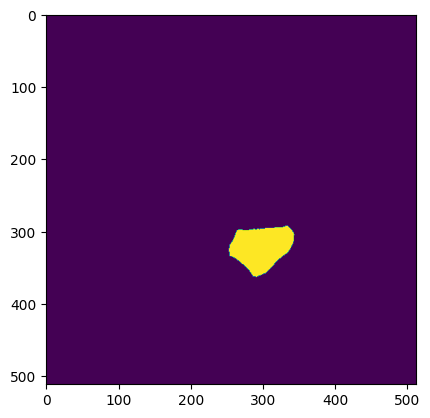

In [54]:
imshow(bla2_arr[169,:,:])

In [57]:
bla4_arr = (seg_mask_arr *bla2_arr)

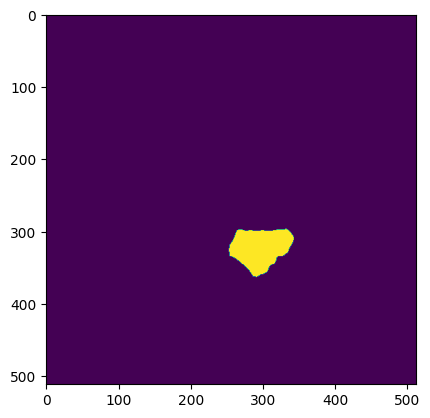

In [58]:
imshow(bla4_arr[169,:,:])

In [59]:
bla4_arr.shape

(271, 512, 512)

In [62]:
min(bla4_arr.shape)

271

In [60]:
271/40

6.775

In [61]:
271/6

45.166666666666664

In [63]:
int(min(bla4_arr.shape)/6)

45

In [113]:
import pandas as pd

In [118]:
df = pd.read_csv('/media/sharedata/atriumCT/corrected_data/GTmasks2/Info.csv', index_col='PID')
df

,corrected
PID,
1,0
4,0
6,1
7,0
8,0
...,...
296,0
297,0
301,0


In [126]:
test = list(df[df['corrected']==1].index.values)

In [129]:
test

[6,
 11,
 13,
 14,
 16,
 17,
 21,
 22,
 23,
 24,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 36,
 40,
 41,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 55,
 56,
 59,
 64,
 65,
 66,
 68,
 76,
 78,
 82,
 86,
 104,
 108,
 111]

In [130]:
10 not in test

True

In [1]:
from os import listdir

In [3]:
list1 = listdir('/media/sharedata/atriumCT/corrected_data/GTmasks2')

In [4]:
list2 = listdir('/media/sharedata/atriumCT/corrected_data/GTlabels')

In [15]:
len(listdir('/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/'))

132

In [16]:
len(listdir('/media/sharedata/atriumCT/atrium_nnunet/raw_data/Dataset004_LA_CT00_corrected_voted/labelsTr/'))

132

In [18]:
import os

In [20]:
path = f'/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/'
files = [f for f in os.listdir( path ) if f[-4:]=='.mha']
len(files)

132

In [28]:

dataset = 'Dataset004_LA_CT00_corrected_voted'
path = f'/media/sharedata/atriumCT/atrium_nnunet/raw_data/{dataset}/prediction_3d_dataset002/'

files = [f for f in os.listdir( path ) if f[-4:]=='.mha']
len(files)
files

['la_trans_corrected_102_061.mha',
 'la_trans_corrected_103_062.mha',
 'la_trans_corrected_104_063.mha',
 'la_trans_corrected_105_064.mha',
 'la_trans_corrected_106_065.mha',
 'la_trans_corrected_107_066.mha',
 'la_trans_corrected_108_067.mha',
 'la_trans_corrected_109_068.mha',
 'la_trans_corrected_110_069.mha',
 'la_trans_corrected_111_070.mha',
 'la_trans_corrected_112_071.mha',
 'la_trans_corrected_113_072.mha',
 'la_trans_corrected_115_073.mha',
 'la_trans_corrected_116_074.mha',
 'la_trans_corrected_118_075.mha',
 'la_trans_corrected_11_004.mha',
 'la_trans_corrected_120_076.mha',
 'la_trans_corrected_123_077.mha',
 'la_trans_corrected_125_078.mha',
 'la_trans_corrected_128_079.mha',
 'la_trans_corrected_131_080.mha',
 'la_trans_corrected_13_005.mha',
 'la_trans_corrected_14_006.mha',
 'la_trans_corrected_150_081.mha',
 'la_trans_corrected_155_082.mha',
 'la_trans_corrected_16_007.mha',
 'la_trans_corrected_17_008.mha',
 'la_trans_corrected_20_009.mha',
 'la_trans_corrected_213_0

In [22]:

mask_path = '/media/sharedata/atriumCT/atrium_nnunet/raw_data/Dataset004_LA_CT00_corrected_voted/labelsTr/'
masks_files = [mask_path + f for f in os.listdir(mask_path)]
ref_label_files = ['/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/' + f  for f in files]
opacification_defect_files = ['/media/sharedata/atriumCT/corrected_data/GTopacification_defect/' + f for f in files]

In [25]:
len(opacification_defect_files)

132

In [6]:
len(list1)

133

In [12]:
for x in list1:
    if x not in list2:
        print(x)
    

Info.csv


In [13]:
list1.remove('Info.csv')

In [14]:
len(list1)

132

In [11]:
list2

['102.mha',
 '103.mha',
 '104.mha',
 '105.mha',
 '106.mha',
 '107.mha',
 '108.mha',
 '109.mha',
 '11.mha',
 '110.mha',
 '111.mha',
 '112.mha',
 '113.mha',
 '115.mha',
 '116.mha',
 '118.mha',
 '120.mha',
 '123.mha',
 '125.mha',
 '128.mha',
 '13.mha',
 '131.mha',
 '14.mha',
 '150.mha',
 '155.mha',
 '16.mha',
 '17.mha',
 '20.mha',
 '21.mha',
 '213.mha',
 '22.mha',
 '227.mha',
 '228.mha',
 '23.mha',
 '230.mha',
 '231.mha',
 '232.mha',
 '233.mha',
 '234.mha',
 '235.mha',
 '236.mha',
 '237.mha',
 '238.mha',
 '239.mha',
 '24.mha',
 '240.mha',
 '241.mha',
 '242.mha',
 '243.mha',
 '244.mha',
 '245.mha',
 '246.mha',
 '247.mha',
 '249.mha',
 '25.mha',
 '251.mha',
 '252.mha',
 '253.mha',
 '254.mha',
 '255.mha',
 '256.mha',
 '257.mha',
 '258.mha',
 '259.mha',
 '260.mha',
 '261.mha',
 '262.mha',
 '263.mha',
 '264.mha',
 '265.mha',
 '267.mha',
 '268.mha',
 '269.mha',
 '27.mha',
 '272.mha',
 '273.mha',
 '274.mha',
 '275.mha',
 '276.mha',
 '277.mha',
 '278.mha',
 '28.mha',
 '282.mha',
 '29.mha',
 '30.m

In [50]:
mask7 = sitk.ReadImage('/media/sharedata/atriumCT/corrected_data/GTmasks2/7.mha')

In [52]:
mask7.GetDirection()

(-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)

In [51]:
mask7.GetDirection() != label7.GetDirection()

True

In [48]:
label7 = sitk.ReadImage('/media/sharedata/atriumCT/corrected_data/GTlabels/7.mha')

In [49]:
label7.GetDirection()

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [56]:
import numpy as np
np.sum(sitk.GetArrayFromImage(label7))

4046795.0

In [58]:
sitk.GetArrayFromImage(label7).shape

(200, 221, 351)

In [59]:
arr = sitk.GetArrayFromImage(label7)

In [63]:
np.sum((sitk.GetArrayFromImage(label7) !=0)) /(arr.shape[0] * arr.shape[1] * arr.shape[2])

0.1631876603369816

In [65]:
len(np.unique(sitk.GetArrayFromImage(label7)))

7

In [66]:
path = f'/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/'
files = [f for f in os.listdir( path ) if f[-4:]=='.mha']
ref_label_files = ['/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/' + f  for f in files]

In [67]:
ref_label_files

['/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/102.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/103.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/104.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/105.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/106.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/107.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/108.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/109.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/11.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/110.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/111.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/112.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/113.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_

In [68]:
len(ref_label_files)

132

In [69]:
ref_label_files = [path + f  for f in os.listdir(path)]

In [70]:
ref_label_files

['/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/102.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/103.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/104.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/105.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/106.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/107.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/108.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/109.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/11.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/110.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/111.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/112.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_reoriented/113.mha',
 '/media/sharedata/atriumCT/corrected_data/GTlabels_

In [75]:
ref_label_files[0].split('/')[-1][:-4]

'102'

In [71]:
len(ref_label_files)

132

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/media/sharedata/atriumCT/atrium_nnunet/nnUNet_results/Dataset004_LA_CT00_corrected_voted/nnUNetTrainer__nnUNetPlans_Dataset002__3d_fullres/fold_0/validation/patients_history_metrics.csv', index_col='Unnamed: 0')
df

,ID,Stroke_ait_history,peripheral_embolism_hist,embolism_hist,verified_thrombus,LAA_opacification_defect,Dice,IoU,nnUnet_id,Contour_Volume,New_dice_auricle,Dice_auricle,Dice_corps,Dice_RSPV_1,Dice_RIPV_2,Dice_LIPV_3,Dice_LSPV_4,Spacing_ref_0,Spacing_ref_1,Spacing_ref_2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
0,6,1,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,1,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,1,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,276,0,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,277,0,0,0,0,1,0.985978,0.972344,128.0,101872.0,0.941244,0.982658,0.997082,0.990721,0.961821,0.974646,0.985610,0.343750,0.343750,0.400002
129,278,1,0,1,1,1,0.981467,0.963608,129.0,233043.0,0.956153,0.989044,0.997673,0.995082,0.983699,0.981941,0.989107,0.371094,0.371094,0.299988


In [3]:
df = df[~df['Dice_auricle'].isna()]
df

,ID,Stroke_ait_history,peripheral_embolism_hist,embolism_hist,verified_thrombus,LAA_opacification_defect,Dice,IoU,nnUnet_id,Contour_Volume,New_dice_auricle,Dice_auricle,Dice_corps,Dice_RSPV_1,Dice_RIPV_2,Dice_LIPV_3,Dice_LSPV_4,Spacing_ref_0,Spacing_ref_1,Spacing_ref_2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
7,16,0,0,0,0,0,0.980751,0.962229,7.0,88747.0,0.957779,0.993246,0.995918,0.895501,0.979806,0.972786,0.979398,0.451172,0.451172,0.400002
14,25,1,0,1,0,0,0.960508,0.924018,14.0,199419.0,0.963212,0.982878,0.977624,0.920300,0.926453,0.833890,0.863993,0.396484,0.396484,0.500000
19,31,0,0,0,0,1,0.972496,0.946464,19.0,78454.0,0.941928,0.992647,0.993572,0.994259,0.981851,0.991372,0.975470,0.498047,0.498047,0.500000
24,40,0,0,0,0,0,0.966363,0.934915,25.0,93942.0,0.883304,0.996619,0.987917,0.913567,0.953483,0.969454,0.975744,0.453125,0.453125,0.500000
31,49,1,0,1,0,1,0.944081,0.894085,32.0,255924.0,0.901223,0.983997,0.987507,0.863602,0.840845,0.972155,0.950035,0.398438,0.398438,0.500000
36,61,0,0,0,0,0,0.953003,0.910225,37.0,207176.0,0.953546,0.974686,0.970723,0.680442,0.954139,0.958201,0.963131,0.326172,0.326172,0.500000
38,65,0,0,0,0,1,0.947739,0.900670,39.0,270701.0,0.870956,0.980945,0.986368,0.983261,0.911947,0.850606,0.882669,0.380859,0.380859,0.500000
43,74,0,0,0,0,0,0.984893,0.970236,44.0,49351.0,0.964603,0.994188,0.996406,0.992833,0.992938,0.992625,0.928810,0.451172,0.451172,0.500000
64,106,1,0,1,0,1,0.974580,0.950421,65.0,121573.0,0.866196,0.979537,0.997082,0.998171,0.989679,0.993545,0.991851,0.437500,0.437500,0.500000


In [4]:
df['New_dice_auricle'].mean()

0.9495276191032155

In [5]:
df['New_dice_auricle'].mean()

0.9417644236950709

In [5]:
df_opa = df[df['LAA_opacification_defect']==1]

In [6]:
df_opa['New_dice_auricle'].mean()

0.933210356733225

In [12]:
df_opa['New_dice_auricle'].mean()

0.9144032719114722

In [14]:
df2

,ID,Stroke_ait_history,peripheral_embolism_hist,embolism_hist,verified_thrombus,LAA_opacification_defect,Dice,IoU,nnUnet_id,Contour_Volume,New_dice_auricle,Dice_auricle,Dice_corps,Dice_RSPV_1,Dice_RIPV_2,Dice_LIPV_3,Dice_LSPV_4,Spacing_ref_0,Spacing_ref_1,Spacing_ref_2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
7,16,0,0,0,0,0,0.979594,0.960005,7.0,11055.0,0.953357,0.957293,0.995562,0.903204,0.980249,0.978390,0.982528,1.121090,0.787109,0.789062
14,25,1,0,1,0,0,0.962267,0.927278,14.0,20059.0,0.962648,0.982171,0.975255,0.922432,0.926865,0.841485,0.859917,1.109375,0.886719,0.761719
19,31,0,0,0,0,1,0.971236,0.944080,19.0,14228.0,0.906260,0.966501,0.992236,0.993826,0.977158,0.992410,0.976480,1.193360,0.792969,0.757812
24,40,0,0,0,0,0,0.967370,0.936802,25.0,14055.0,0.890979,0.968935,0.986561,0.928408,0.954481,0.967742,0.986492,1.167970,0.759766,0.753906
31,49,1,0,1,0,1,0.945752,0.897086,32.0,27362.0,0.884895,0.902643,0.985999,0.864816,0.831172,0.974051,0.947176,1.107420,0.791016,0.824219
36,61,0,0,0,0,0,0.960345,0.923715,37.0,321312.0,0.956966,0.925526,0.977880,0.687622,0.954290,0.939396,0.957766,0.307629,0.307629,0.307629
38,65,0,0,0,0,1,0.948063,0.901255,39.0,31043.0,0.861109,0.900734,0.984799,0.983057,0.909438,0.852078,0.885603,1.080080,0.732422,0.796875
43,74,0,0,0,0,0,0.984871,0.970194,44.0,87562.0,0.963073,0.991701,0.996841,0.994188,0.993343,0.993148,0.924910,0.386064,0.386064,0.386064
64,106,1,0,1,0,1,0.975513,0.952196,65.0,169737.0,0.840898,0.773823,0.996666,0.997730,0.986200,0.982809,0.993261,0.404168,0.404168,0.404168


In [15]:
df_opa2

,ID,Stroke_ait_history,peripheral_embolism_hist,embolism_hist,verified_thrombus,LAA_opacification_defect,Dice,IoU,nnUnet_id,Contour_Volume,New_dice_auricle,Dice_auricle,Dice_corps,Dice_RSPV_1,Dice_RIPV_2,Dice_LIPV_3,Dice_LSPV_4,Spacing_ref_0,Spacing_ref_1,Spacing_ref_2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
19,31,0,0,0,0,1,0.971236,0.944080,19.0,14228.0,0.906260,0.966501,0.992236,0.993826,0.977158,0.992410,0.976480,1.193360,0.792969,0.757812
31,49,1,0,1,0,1,0.945752,0.897086,32.0,27362.0,0.884895,0.902643,0.985999,0.864816,0.831172,0.974051,0.947176,1.107420,0.791016,0.824219
38,65,0,0,0,0,1,0.948063,0.901255,39.0,31043.0,0.861109,0.900734,0.984799,0.983057,0.909438,0.852078,0.885603,1.080080,0.732422,0.796875
64,106,1,0,1,0,1,0.975513,0.952196,65.0,169737.0,0.840898,0.773823,0.996666,0.997730,0.986200,0.982809,0.993261,0.404168,0.404168,0.404168
73,116,0,0,0,0,1,0.979269,0.959380,74.0,156791.0,0.905903,0.875376,0.997337,0.965419,0.982501,0.965042,0.990013,0.371915,0.371915,0.371915
75,120,1,0,1,0,1,0.983451,0.967441,76.0,114949.0,0.958122,0.945998,0.998093,0.999092,0.997113,0.999164,0.993800,0.483086,0.483086,0.483086
81,155,1,0,1,0,1,0.976563,0.954199,82.0,192838.0,0.949941,0.877267,0.990816,0.975155,0.965186,0.976649,0.882664,0.348343,0.348343,0.348343
95,239,1,0,1,0,1,0.983840,0.968193,95.0,114910.0,0.939447,0.927035,0.996573,0.997083,0.983853,0.991012,0.995295,0.432566,0.432566,0.432566
100,244,0,0,0,0,1,0.985729,0.971860,100.0,108787.0,0.959473,0.954247,0.997007,0.985119,0.996445,0.996740,0.996675,0.373472,0.373472,0.373472


In [8]:
df2 = pd.read_csv('/media/sharedata/atriumCT/atrium_nnunet/nnUNet_results/Dataset004_LA_CT00_corrected_voted/nnUNetTrainer__nnUNetPlans_Dataset002__3d_fullres_lr_06_1500_epochs/fold_0/validation/patients_history_metrics.csv', index_col='Unnamed: 0')
df2 = df2[~df2['Dice_auricle'].isna()]

In [9]:
df2['New_dice_auricle'].mean()

0.9498713772847118

In [7]:
df2['New_dice_auricle'].mean()

0.9423925165778909

In [13]:
df_opa2 = df2[df2['LAA_opacification_defect']==1]
df_opa2['New_dice_auricle'].mean()

0.9170812561234913

In [10]:
df3 = pd.read_csv('/media/sharedata/atriumCT/atrium_nnunet/nnUNet_results/Dataset004_LA_CT00_corrected_voted/nnUNetTrainer__nnUNetPlans_Dataset002__3d_fullres_1er_test/fold_0/validation/patients_history_metrics.csv', index_col='Unnamed: 0')
df3 = df3[~df3['Dice_auricle'].isna()]

In [11]:
df3['New_dice_auricle'].mean()

0.9123193048289298

In [9]:
df3['New_dice_auricle'].mean()

0.9035820637173196

In [17]:
import pandas as pd

In [18]:
df4 = pd.read_csv('/media/sharedata/atriumCT/atrium_nnunet/nnUNet_results/Dataset005_LA_CT00_corrected_voted_region/nnUNetTrainer__nnUNetPlans_Dataset002__3d_fullres/fold_0/prediction_500/patients_history_metrics.csv', index_col='Unnamed: 0')
df4 = df4[~df4['Dice_auricle'].isna()]

In [3]:
df4['New_dice_auricle'].mean()

0.948144704335795

In [4]:
df_opa4 = df4[df4['LAA_opacification_defect']==1]
df_opa4['New_dice_auricle'].mean()

0.936854977922195

# RELANCER CALCUL DE METRIQUES AVEC NOUVELLE LABELLISATION
# PUIS CALCULER METRIQUES SUR LES LABELS

In [13]:
df['New_dice_auricle'].mean()

0.9495276191032155

In [14]:
df2['New_dice_auricle'].mean()

0.9498713772847118

In [15]:
df3['New_dice_auricle'].mean()

0.9123193048289298

In [19]:
df4['New_dice_auricle'].mean()

0.948144704335795

In [21]:
df_opa = df[df['LAA_opacification_defect']==1]
df_opa['New_dice_auricle'].mean()

0.933210356733225

In [22]:
df_opa2 = df2[df2['LAA_opacification_defect']==1]
df_opa2['New_dice_auricle'].mean()

0.9351265603037262

In [23]:
df_opa3 = df3[df3['LAA_opacification_defect']==1]
df_opa3['New_dice_auricle'].mean()

0.876944817837498

In [24]:
df_opa4 = df4[df4['LAA_opacification_defect']==1]
df_opa4['New_dice_auricle'].mean()

0.936854977922195

NameError: name 'pl' is not defined

In [2]:
import numpy as np

In [16]:
ar = np.array([0.0,1.0,0.75], dtype=np.float32)

In [17]:
ar

array([0.  , 1.  , 0.75], dtype=float32)

In [18]:
print(np.unique(ar))

[0.   0.75 1.  ]


In [10]:
import SimpleITK as sitk

In [11]:
arr = sitk.GetArrayFromImage(sitk.ReadImage(f'/media/sharedata/atriumCT/corrected_data/GTmasks2/31.mha'))

In [19]:
np.unique(arr)

array([0., 1.], dtype=float32)

In [20]:
label = sitk.ReadImage(f'/media/sharedata/atriumCT/corrected_data/GTlabels_with_opa_defect/16.mha')

In [21]:
label_arr = sitk.GetArrayFromImage(label)

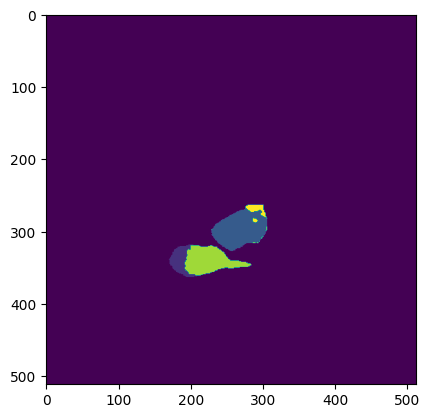

In [25]:
from matplotlib.pyplot import imshow

slices = 245
imshow(label_arr[slices,:,:])

In [28]:
auricle = ((label == 2)|(label == 7))
auricle_arr = sitk.GetArrayFromImage(auricle)

In [29]:
opa_defect = (label == 7)
opa_defect_arr = sitk.GetArrayFromImage(opa_defect)

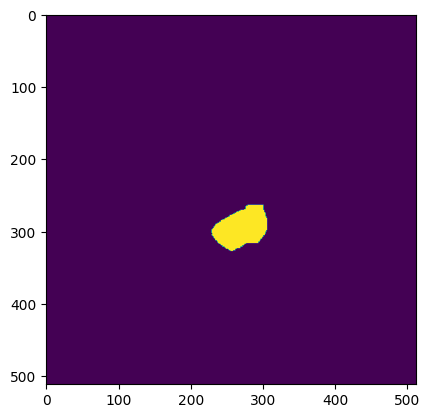

In [30]:
imshow(auricle_arr[slices,:,:])

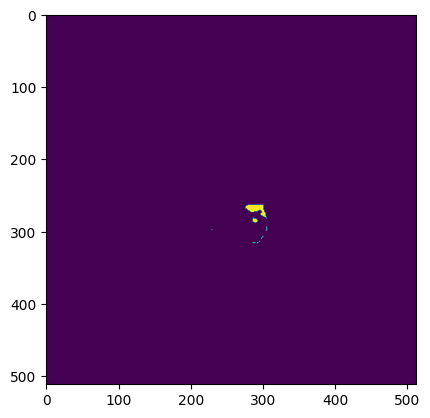

In [31]:
imshow(opa_defect_arr[slices,:,:])

In [34]:
opa_defect_arr.sum() / auricle_arr.sum() * 100

8.937718139177402

In [37]:
'/media/sharedata/atriumCT/corrected_data/GTlabels_with_opa_defect/16.mha'[:-4]

'/media/sharedata/atriumCT/corrected_data/GTlabels_with_opa_defect/16'

In [39]:
import pandas as pd

In [44]:
df = pd.read_csv('/media/sharedata/atriumCT/atrium_nnunet/raw_data/Dataset005_LA_CT00_corrected_voted_region/labelsTr/patients_history_percentage_opa.csv', index_col='ID')

In [46]:

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [47]:
df

,Unnamed: 0,Stroke_ait_history,peripheral_embolism_hist,embolism_hist,verified_thrombus,LAA_opacification_defect,Dice,IoU,nnUnet_id,Opa_percentage
ID,,,,,,,,,,
6,0,1,0,1,0,0,0.902653,0.822578,0.0,14.845918
7,1,1,0,1,0,1,0.908900,0.833013,1.0,53.393807
8,2,0,0,0,0,0,0.963089,0.928806,2.0,1.530771
9,3,1,0,1,0,1,0.980152,0.961077,3.0,1.821576
11,4,0,0,0,0,0,NaN,NaN,NaN,2.338858
13,5,0,0,0,0,0,0.950502,0.905673,4.0,3.413421
14,6,1,0,1,0,1,0.969161,0.940168,5.0,19.674916
16,7,0,0,0,0,0,0.976274,0.953648,6.0,8.937718
17,8,0,0,0,0,1,0.965133,0.932615,7.0,66.411254


In [53]:
df['opacification'] = (df['Opa_percentage']>10).astype(int)

In [54]:
df

,Unnamed: 0,Stroke_ait_history,peripheral_embolism_hist,embolism_hist,verified_thrombus,LAA_opacification_defect,Dice,IoU,nnUnet_id,Opa_percentage,opacification
ID,,,,,,,,,,,
6,0,1,0,1,0,0,0.902653,0.822578,0.0,14.845918,1
7,1,1,0,1,0,1,0.908900,0.833013,1.0,53.393807,1
8,2,0,0,0,0,0,0.963089,0.928806,2.0,1.530771,0
9,3,1,0,1,0,1,0.980152,0.961077,3.0,1.821576,0
11,4,0,0,0,0,0,NaN,NaN,NaN,2.338858,0
13,5,0,0,0,0,0,0.950502,0.905673,4.0,3.413421,0
14,6,1,0,1,0,1,0.969161,0.940168,5.0,19.674916,1
16,7,0,0,0,0,0,0.976274,0.953648,6.0,8.937718,0
17,8,0,0,0,0,1,0.965133,0.932615,7.0,66.411254,1


In [57]:
df[df['opacification']!=df['LAA_opacification_defect']].sort_values('Opa_percentage')

,Unnamed: 0,Stroke_ait_history,peripheral_embolism_hist,embolism_hist,verified_thrombus,LAA_opacification_defect,Dice,IoU,nnUnet_id,Opa_percentage,opacification
ID,,,,,,,,,,,
38,23,0,0,0,1,1,0.933602,0.875472,23.0,0.229008,0
238,94,1,0,1,0,1,0.946182,0.897861,93.0,0.843462,0
9,3,1,0,1,0,1,0.980152,0.961077,3.0,1.821576,0
76,45,0,0,0,1,1,0.968862,0.939604,45.0,9.829277,0
78,47,0,0,0,0,0,0.964329,0.931115,47.0,10.086750,1
40,24,0,0,0,0,0,0.952210,0.908779,24.0,10.266389,1
30,18,0,0,0,0,0,0.953032,0.910279,17.0,11.042445,1
66,39,0,0,0,0,0,0.969532,0.940866,39.0,12.670873,1
251,105,0,0,0,0,0,0.934703,0.877411,104.0,12.786439,1


In [56]:
df[df['opacification']!=df['LAA_opacification_defect']].shape

(22, 11)

In [1]:
import SimpleITK as sitk

In [15]:
image = sitk.ReadImage(f'/media/sharedata/atriumCT/atrium_nnunet/raw_data/Dataset005_LA_CT00_corrected_voted_region/imagesTr/la_lables_opa_defect_31_019_0000.mha')

In [16]:
arr = sitk.GetArrayFromImage(image)

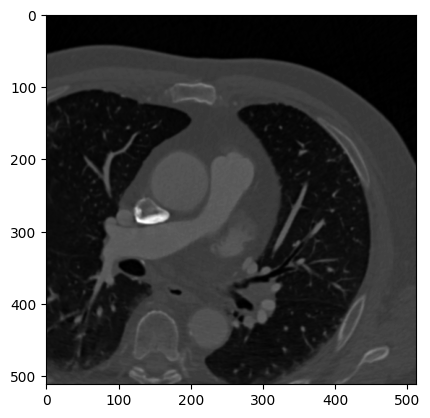

In [18]:
from matplotlib.pyplot import imshow

slices = 197
imshow(arr[slices,:,:], cmap='gray')

In [20]:
import numpy as np

In [21]:
lower_bound = -150
upper_bound = 350
image_new = np.clip(arr, lower_bound, upper_bound)
image_new = (image_new - lower_bound) / (upper_bound - lower_bound)

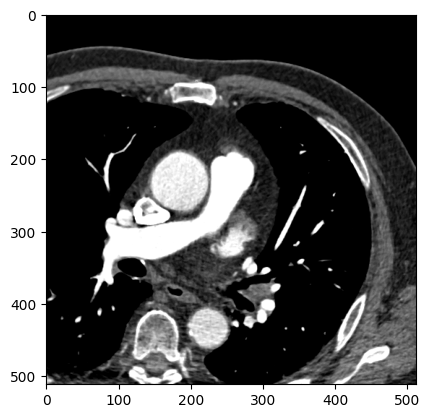

In [22]:
imshow(image_new[slices,:,:], cmap='gray')